In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

import os
import pandas as pd

from PIL import Image

from matplotlib import pyplot as plt

In [2]:
torch.cuda.is_available()

True

In [3]:
# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# create a custom dataset
transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor()
])

class TabMagicDataset(Dataset):
    def __init__(self,
                 data_path: str,
                 annotation_path: str,
                 transform: transforms.Compose = None):
        self.transform = transform
        # Load and preprocess the data
        self.image_paths = [os.path.join(data_path, img) for img in os.listdir(data_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
        self.annotations_df = pd.read_csv(annotation_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        # Get corresponding annotation
        img_name = os.path.basename(img_path)
        #print(img_name)
        annotations = self.annotations_df[self.annotations_df['image_name'] == img_name]
        
        # Extract labels from annotation
        labels = []
        boxes = []
        for _, annotation in annotations.iterrows():
            boxes.append([
                annotation['bbox_x'],
                annotation['bbox_y'],
                annotation['bbox_x'] + annotation['bbox_width'],
                annotation['bbox_y'] + annotation['bbox_height']
            ])
            labels.append(1)

        # Convert to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels
        }

        if self.transform:
            # Get original dimensions
            original_width, original_height = image.size
            
            # Apply transformations
            image = self.transform(image)
            
            # Get new dimensions
            new_width, new_height = image.shape[2], image.shape[1]
            
            # Calculate scaling factors
            scale_x = new_width / original_width
            scale_y = new_height / original_height
            
            # Scale bounding boxes
            boxes = target['boxes']
            boxes[:, [0, 2]] *= scale_x
            boxes[:, [1, 3]] *= scale_y
            target['boxes'] = boxes
        
        return image, target

In [5]:
# Custom collate function
def collate_fn(batch):
    images, targets = zip(*batch)
    images = list(images)
    targets = [{k: v for k, v in t.items()} for t in targets]
    return images, targets

In [6]:
# create instance of Dataset
dataset = TabMagicDataset(
    data_path='data/features/tabs',
    annotation_path='data/labels/bars/labels_tabmagic_2024-08-01-03-25-24.csv',
    transform=transform
)

In [7]:
# make sure our dataset works
len(dataset)

87

In [8]:
image, lbl = dataset[3]
print(image, lbl)

tensor([[[0.9608, 0.9608, 0.6549,  ..., 0.9608, 0.9608, 0.9608],
         [0.9608, 0.9608, 0.8392,  ..., 0.9608, 0.9608, 0.9608],
         [0.9608, 0.9608, 0.9608,  ..., 0.9608, 0.9608, 0.9608],
         ...,
         [0.9608, 0.9608, 0.9608,  ..., 0.9608, 0.9608, 0.9608],
         [0.9608, 0.9608, 0.9608,  ..., 0.9608, 0.9608, 0.9608],
         [0.9608, 0.9608, 0.9608,  ..., 0.9608, 0.9608, 0.9608]],

        [[0.9608, 0.9608, 0.5412,  ..., 0.9608, 0.9608, 0.9608],
         [0.9608, 0.9608, 0.7373,  ..., 0.9608, 0.9608, 0.9608],
         [0.9608, 0.9608, 0.8980,  ..., 0.9608, 0.9608, 0.9608],
         ...,
         [0.9608, 0.9608, 0.9608,  ..., 0.9608, 0.9608, 0.9608],
         [0.9608, 0.9608, 0.9608,  ..., 0.9608, 0.9608, 0.9608],
         [0.9608, 0.9608, 0.9608,  ..., 0.9608, 0.9608, 0.9608]],

        [[0.9608, 0.8471, 0.6196,  ..., 0.9608, 0.9608, 0.9608],
         [0.9608, 0.9176, 0.6392,  ..., 0.9608, 0.9608, 0.9608],
         [0.9608, 0.9608, 0.7608,  ..., 0.9608, 0.9608, 0.

In [9]:
image.shape

torch.Size([3, 1024, 1024])

The data is formatted as follows:

`(Data, Labels)`

where Data is a NCHW formatted tensor, and Labels is a list of objects that specifies the bounding box coordinates of each tab location, specified in x_max, y_max (i.e. the TL bounding box corner), h, w format

(-0.5, 1023.5, 1023.5, -0.5)

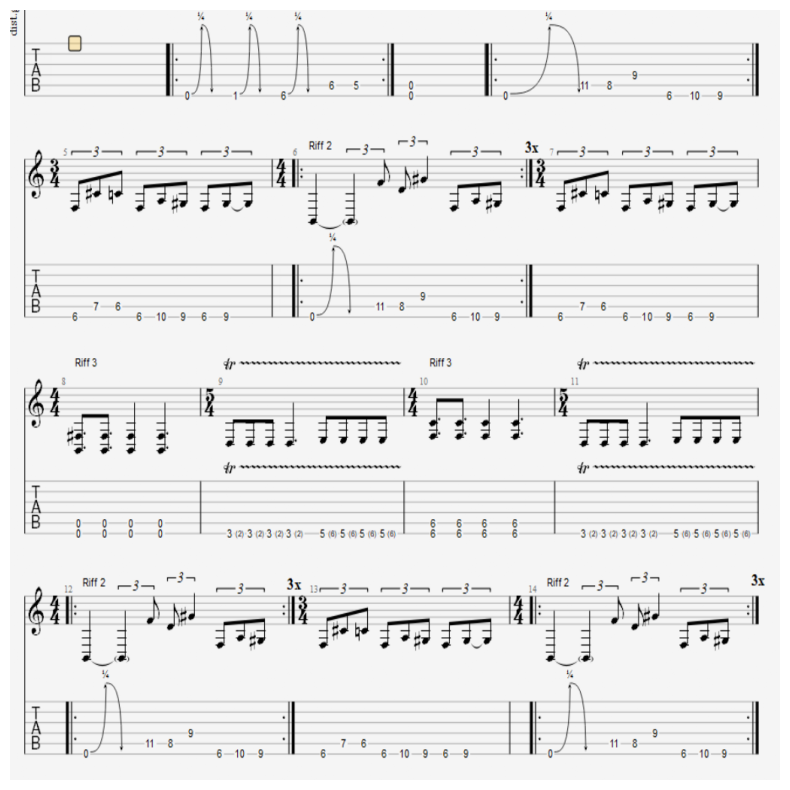

In [10]:
# show an example image using matplotlib

img_np = image.numpy().transpose((1, 2, 0)) # remember, numpy uses HWC
# note: fastercnn_resnet50_fpn is in CWH format, so this is done only for
# visualization purposes

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(img_np)
plt.axis('off')

In [11]:
# instantiate the faster RCNN model
# I am using fasterrcnn_resnet50_fpn and finetuning it
model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=True)
num_classes = 2 # 1 for background, 1 for tab bars


c:\Users\cakec\Desktop\tabmagic\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\cakec\Desktop\tabmagic\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [13]:
# remove the cls_score and bbox_pred layers:
# get the appropriate amount of in_features to feed our model
in_features = model.roi_heads.box_predictor.cls_score.in_features
in_features

1024

In [14]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# replace the pre-trained head
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
# move the model to the GPU
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [15]:
# train test split
from torch.utils.data import random_split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

#torch.manual_seed(42)
train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [16]:
# get our train and test dataloaders:
train_dl = DataLoader(
    train_ds, 
    batch_size=2, 
    shuffle=True,
    collate_fn=collate_fn
)
test_dl = DataLoader(
    val_ds,
    batch_size=2,
    shuffle=False,
    collate_fn=collate_fn
)

In [17]:
# setup training
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005) # use SGD as an optimizer
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
train_losses = []
val_losses = []
num_epochs = 10
for epoch in range(num_epochs):
    # train loop
    model.train()
    train_loss = 0
    for images, targets in train_dl:
        # move images and labels to device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]

        # optimizer zero grad
        optimizer.zero_grad()

        # forward step
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        # loss backwards
        losses.backward()

        # optimizer step
        optimizer.step()

        train_loss += losses.item()
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, targets in test_dl:
            # same thing as train loop, but no optim. ZG, backprop, or optim. step
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
            
            # Ensure loss_dict is a dictionary
            if isinstance(loss_dict, dict):
                losses = sum(loss for loss in loss_dict.values())
                val_loss += losses.item()
     # Calculate average losses
    train_loss /= len(train_dl)
    val_loss /= len(test_dl)
    train_losses.append(train_loss)
    val_losses.append(val_loss)


    # Print losses
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    lr_scheduler.step()

Epoch 1/10, Training Loss: 1.0782, Validation Loss: 0.9552
Epoch 2/10, Training Loss: 0.3332, Validation Loss: 0.2384
Epoch 3/10, Training Loss: 0.2356, Validation Loss: 0.2154
Epoch 4/10, Training Loss: 0.1744, Validation Loss: 0.1551
Epoch 5/10, Training Loss: 0.1437, Validation Loss: 0.1938
Epoch 6/10, Training Loss: 0.1421, Validation Loss: 0.1134
Epoch 7/10, Training Loss: 0.1343, Validation Loss: 0.1116
Epoch 8/10, Training Loss: 0.1322, Validation Loss: 0.0907
Epoch 9/10, Training Loss: 0.1333, Validation Loss: 0.1331
Epoch 10/10, Training Loss: 0.1304, Validation Loss: 0.1055


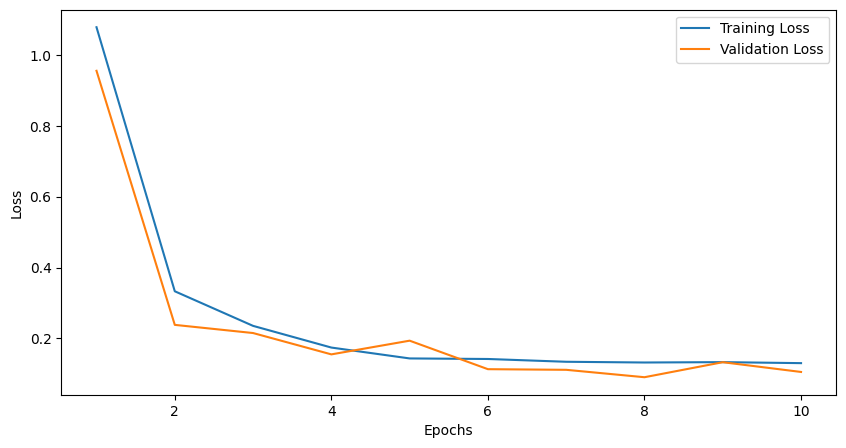

In [18]:
# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
# apply NMS to remove significant overlapping boxes
from torchvision.ops import nms

def apply_nms(boxes, scores, iou_threshold=0.5):
    keep = nms(boxes, scores, iou_threshold)
    return boxes[keep], scores[keep]

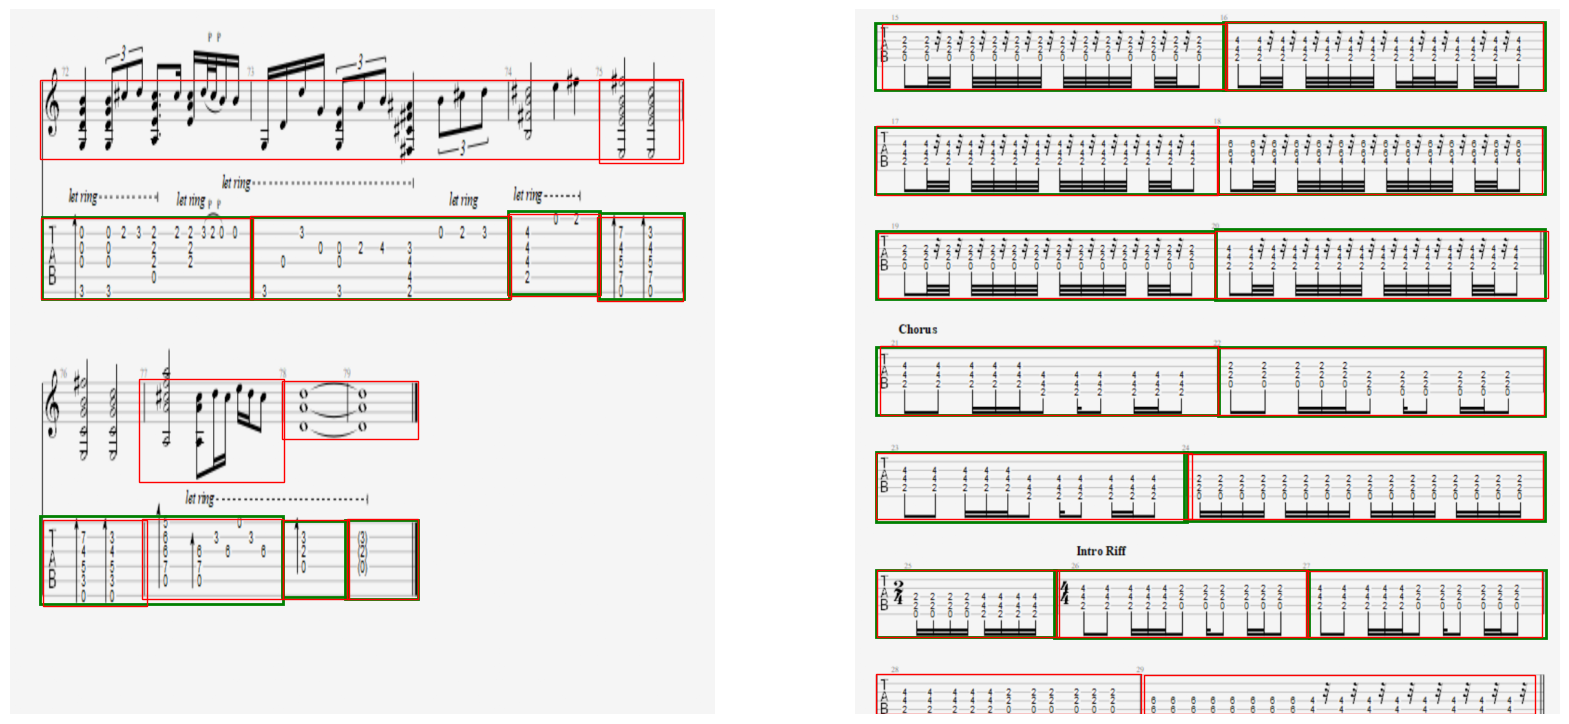

In [20]:
# Visualize predictions
import matplotlib.patches as patches
def visualize_predictions(model, dataset, device, num_images=2):
    model.eval()
    fig, axs = plt.subplots(1, num_images, figsize=(20, 20))
    with torch.no_grad():
        for i in range(num_images):
            image, target = dataset[i]
            image = image.to(device)
            prediction = model([image])[0]

            #apply NMS:
            boxes = prediction['boxes'].cpu()
            scores = prediction['scores'].cpu()
            boxes, scores = apply_nms(boxes, scores, 0.25)
            
            # Convert image to numpy for plotting
            image_np = image.cpu().numpy().transpose((1, 2, 0))
            
            # Plot image
            axs[i].imshow(image_np)
            axs[i].axis('off')
            
            # Plot ground truth boxes (green)
            for box in target['boxes']:
                rect = patches.Rectangle((box[0].item(), box[1].item()), 
                                         (box[2] - box[0]).item(), 
                                         (box[3] - box[1]).item(), 
                                         linewidth=2, edgecolor='g', facecolor='none')
                axs[i].add_patch(rect)
            
            
            # Plot predicted boxes
            for box in boxes:
                rect = patches.Rectangle((box[0].item(), box[1].item()), 
                                         (box[2] - box[0]).item(), 
                                         (box[3] - box[1]).item(), 
                                         linewidth=1, edgecolor='r', facecolor='none')
                axs[i].add_patch(rect)
    
    plt.show()

# Visualize predictions on test set
visualize_predictions(model, val_ds, device)

In [21]:
# save the model to use in TabMagic
os.makedirs('models', exist_ok=True)
torch.save(model.state_dict(), os.path.join('models', 'tabmagic_model.pth'))